In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
pi=np.pi
pm = np.array((-1,1))
r2d,d2r = 180/pi,pi/180
r2d2,d2r2  = 90/pi,pi/90
ori_wrap = lambda x: SDF.wrap(x*2)/2

import SD_functions as SDF
import responseModel as RM

In [126]:
def sav_fig(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)
    
def sav_fig2(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.eps',dpi=1200)

In [6]:
EV = pd.read_csv('data/task_events_local_v9.csv',index_col=0)

# Pooled Bias

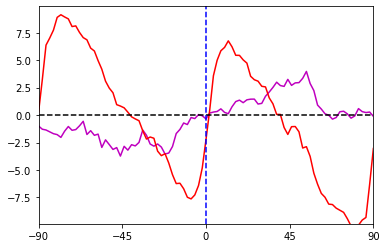

In [25]:
nb=-1
d_ori = SDF.get_nb(nb,EV['correctAngle'].values,1,ori_wrap)


# d_ori = np.concatenate(([0],SDF.wrap(EV['correctAngle'].values[:-1]-EV['correctAngle'].values[1:])))
n_bns = 91
bns = np.linspace(-90,90,n_bns)
overlap = 3
this_sd = SDF.do_bining(bns,overlap,d_ori,EV['E']*d2r2,want_var='circ_mean')*r2d2

this_cb = SDF.do_bining(bns,overlap,EV.correctAngle,EV['E']*d2r2,want_var='circ_mean')*r2d2
this_cv = SDF.do_bining(bns,overlap*4,EV.correctAngle,EV['E']*d2r2,want_var='circ_var')
# plt.plot(bns,this_sd)
plt.plot(bns,this_sd,'m')
plt.plot(bns,this_cb,color='r')
SDF.d_plot(1,9.9,-90)
plt.show()

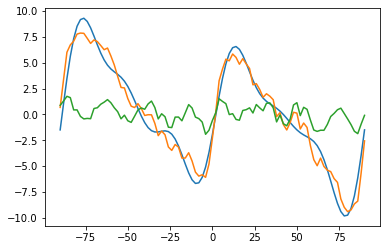

0.6289244826203303
6840
18
21.471849918636636


In [29]:
# lets fit fourier, etc.

# inds = (cEV.taskVersion=='local_v9')
cEV=EV
stim = cEV.loc[:,'correctAngle'].values+90
resp = cEV.loc[:, 'respAngle'].values+90
E = cEV.loc[:, 'E'].values
subjs = cEV.loc[:, 'subject'].values.astype(str)

# corr_fun, bias = RM.correct_cb(stim,resp,E,c_fun='sine',mode='fit_fun')
# corr_fun, bias = RM.correct_cb(stim,resp,E,c_fun='sawtooth',mode='fit_fun')
corr_fun, bias = RM.correct_cb(stim,resp,E,c_fun='fourier',n_param=12,mode='fit_fun')

plt.plot(bns,corr_fun(bns*d2r*2))
plt.plot(bns,bias[0])
plt.plot(bns,bias[1])
# plt.title(this_task)
plt.show()


print(SDF.circ_corr(stim*d2r*2,resp*d2r*2))
print(len(subjs))
print(len(np.unique(subjs)))
print(np.std(E))

In [104]:
nb_run = (-7,-5,-3,-2,-1,1,0)
# nb_run = (-3,-1,0)

n_trial = 360
n_subj = len(stim)//n_trial
do_boot = 1024
if do_boot:
    n_subj = do_boot

# _,_resp,E_corrected = RM.correct_cb(stim,resp,E,c_fun='sawtooth',mode='E')#,subjs=subjs)#,n_subj=n_subj,n_trial=n_trial)
_,_resp,E_corrected = RM.correct_cb(stim,resp,E,c_fun='fourier',n_param=12,mode='E')#,subjs=subjs)#,n_subj=n_subj,n_trial=n_trial)

n_trial_total = len(E_corrected[0])
resp_stack = np.concatenate([_resp,_resp])
E_stack = np.stack([E[:n_trial_total],E_corrected[0]])
stats,bias_curve = RM.summarize_sim(stim[:n_trial_total],resp_stack,E_stack,n_subj=n_subj,n_trial=n_trial,nb_run=nb_run,
                       labs=('Raw','Corrected'),do_boot=do_boot,get_vis=1,subjs=None)


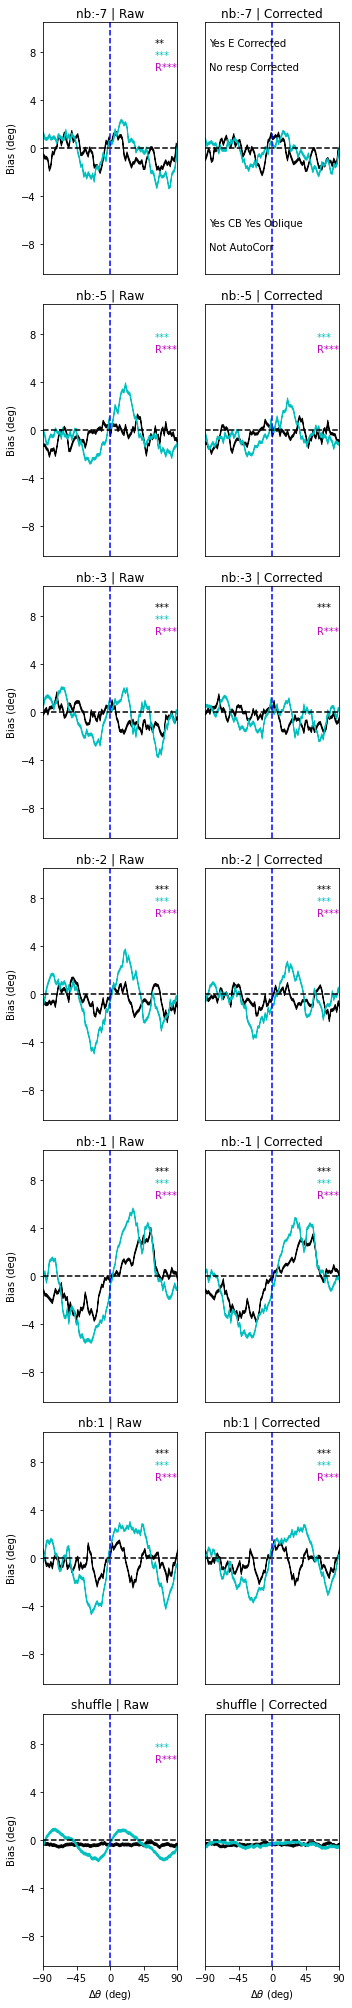

In [108]:
ann = (1,0,0,1,1)
nb_use = (-2,-1,0)
nb_use = nb_run
RM.vis_bias(bias_curve,nb_use,stats=stats,ann=ann,labs=('Raw','Corrected'))
# sav_fig('F7_emp_local_v9_full_nb_1')

In [428]:
# sns.catplot(data=stats[stats.subj<350],x='nb',y='amp',hue='dStim',kind='boxen',col='trueSD',ci=95)
# plt.show()

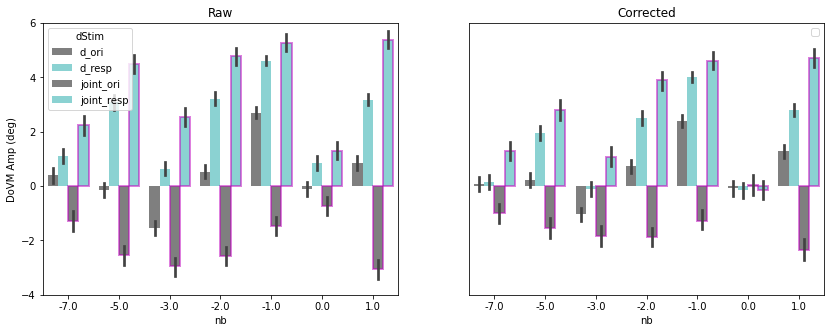

In [145]:
htc = '///'
htc = ''
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
al = .5
yl = (-4,6)
# sns.barplot(data=stats[stats.trueSD=='Raw'],x='nb',y='amp',hue='dStim',ci=95,palette=['k','c'],alpha=al)
bar = sns.barplot(data=stats[stats.trueSD=='Raw'],x='nb',y='amp',hue='dStim',ci=95,palette=['k','c'],alpha=al)
for i,thisbar in enumerate(bar.patches):
    if i>=(len(bar.patches)/2):
        thisbar.set_edgecolor('m')
        thisbar.set_linewidth(2)
#         thisbar.set_hatch(htc)
plt.ylabel('DoVM Amp (deg)')
plt.title('Raw')
plt.ylim(yl)
# plt.legend([])


plt.subplot(1,2,2)
# sns.barplot(data=stats[stats.trueSD=='Corrected'],x='nb',y='amp',hue='dStim',ci=95,palette=['k','c'],alpha=al)
bar = sns.barplot(data=stats[stats.trueSD=='Corrected'],x='nb',y='amp',hue='dStim',ci=95,palette=['k','c'],alpha=al)
for i,thisbar in enumerate(bar.patches):
    if i>=(len(bar.patches)/2):
        thisbar.set_edgecolor('m')
        thisbar.set_linewidth(2)
#         thisbar.set_hatch(htc)
plt.ylabel('DoVM Amp (deg)')
plt.title('Corrected')
plt.legend([])
plt.yticks([])
plt.ylabel('')
plt.ylim(yl)
# sav_fig('F7_emp_local_v9_bars_full_outline')
plt.show()

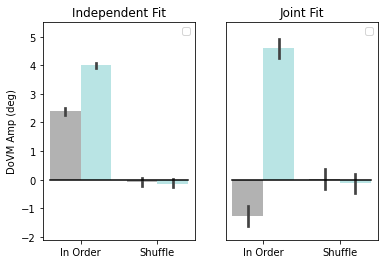

In [129]:
# sns.catplot(data=stats,x='nb',y='amp',hue='dStim',kind='bar',col='trueSD',ci=68)
# plt.title(this_task)
# # sav_fig('F7_emp_local_v9_bars_full')
# plt.show()
al=.3
yl = (-2.1,5.5)
plt.subplot(1,2,1)
sns.barplot(data=stats[(stats.trueSD=='Corrected')&(stats.nb>=-1)&(stats.nb<1)&np.isin(stats.dStim,('d_ori','d_resp'))],
            x='nb',y='amp',hue='dStim',palette=['k','c'],ci=68,alpha=al)
plt.ylim(yl)
plt.ylabel('DoVM Amp (deg)')
plt.xticks([0,1],['In Order','Shuffle'])
# plt.xlabel('Order')
plt.xlabel('')
plt.legend([])
plt.title('Independent Fit')
plt.plot([-.4,2.4-1],[0,0],'k')



plt.subplot(1,2,2)
bar = sns.barplot(data=stats[(stats.trueSD=='Corrected')&(stats.nb>=-1)&(stats.nb<1)&~np.isin(stats.dStim,('d_ori','d_resp'))],
            x='nb',y='amp',hue='dStim',palette=['k','c'],ci=95,alpha=al)

for i,thisbar in enumerate(bar.patches):
    thisbar.set_hatch(htc)
plt.ylim(yl)
plt.ylabel('')
plt.yticks([])
plt.xticks([0,1],['In Order','Shuffle'])
# plt.xlabel('Order')
plt.xlabel('')
plt.title('Joint Fit')
plt.plot([-.4,2.4-1],[0,0],'k')
plt.legend([])
sav_fig('F7_emp_local_v9_bars_hatch')
plt.show()

In [112]:
import scipy.stats
vals0 = (stats[(stats.trueSD=='Corrected')&(stats.nb==-1)&(stats.dStim=='d_ori')].amp.values,
        stats[(stats.trueSD=='Corrected')&(stats.nb==-1)&(stats.dStim=='d_resp')].amp.values)

vals1 = (stats[(stats.trueSD=='Corrected')&(stats.nb==-1)&(stats.dStim=='joint_ori')].amp.values,
        stats[(stats.trueSD=='Corrected')&(stats.nb==-1)&(stats.dStim=='joint_resp')].amp.values)

vals2 = (stats[(stats.trueSD=='Corrected')&(stats.nb==0)&(stats.dStim=='joint_ori')].amp.values,
        stats[(stats.trueSD=='Corrected')&(stats.nb==0)&(stats.dStim=='joint_resp')].amp.values)
scipy.stats.ttest_1samp(vals0[1],0)
scipy.stats.ttest_1samp(vals1[1],0)
# scipy.stats.ttest_rel(vals0[0],vals0[1])
# scipy.stats.ttest_1samp(vals2[1],0)
# scipy.stats.ttest_1samp(vals2[1],0)

Ttest_1sampResult(statistic=-0.7529000168094081, pvalue=0.45168321667728073)

In [715]:
scipy.stats.ttest_1samp(vals1[1],0)

Ttest_1sampResult(statistic=28.760286101226985, pvalue=8.825394928666338e-134)

In [712]:
scipy.stats.ttest_rel(vals1[0],vals1[1])

Ttest_relResult(statistic=-18.498420813003637, pvalue=3.944224070004513e-66)

In [115]:
nb_run

(-7, -5, -3, -2, -1, 1, 0)

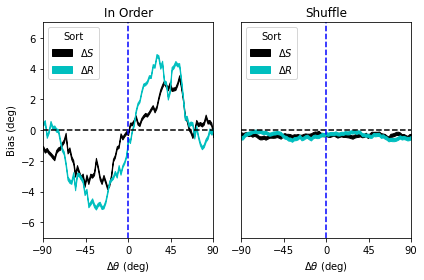

In [118]:
do_correction = 1


# plt.subplot(1,3,1)
# plt.plot(bns,bias[0],color='gray',linewidth=4,label='Cardinal Bias')
# plt.plot(bns,corr_fun(bns*d2r*2),'r--',label='Model Fit')
# plt.plot(bns,bias[1],'g',label='Residuals')
# plt.legend()
# # plt.title(this_task)
# plt.title('History Independent Biases')
# plt.xlabel('$\\theta$ (deg)')
# plt.ylabel('Bias (deg)')


plt.figure(figsize=(6,4))
SDF.d_plot(1,9.9,-90)
for i in range(2):
    plt.subplot(1,2,i+1)
    SDF.sem_plot(bns,bias_curve[len(nb_run)-3+i*2,0,do_correction,],color='k',label='$\Delta S$')
    SDF.sem_plot(bns,bias_curve[len(nb_run)-3+i*2,1,do_correction,],color='c',label='$\Delta R$')
    SDF.d_plot(1,7,-90)
    foo = (1,'shuffle')[i]
    foo = ('In Order','Shuffle')[i]
    plt.title(f'{foo}')
    plt.xlabel('$\Delta\\theta$ (deg)')
    if i==0:
        plt.ylabel('Bias (deg)')
    else:
        plt.yticks([])
    plt.legend(title='Sort',loc=2)
plt.tight_layout()
# sav_fig('F7_emp_local_v9_cb_bias_curves')
plt.show()

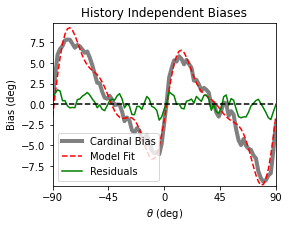

In [113]:
# plt.hist(E_stack[0],bns,density=1,histtype='step')
def l_fun(amp,x): return -np.sum(np.log(scipy.stats.vonmises(amp).pdf(x)+.01))
r_bns = bns*d2r*2
this_E = E_stack[1]*d2r*2

fit_fun = scipy.optimize.minimize(l_fun,x0=(2,),args=(this_E))

plt.figure(figsize=(4,3))
# plt.subplot(1,2,1)
plt.plot(bns,bias[0],color='gray',linewidth=4,label='Cardinal Bias')
plt.plot(bns,corr_fun(bns*d2r*2),'r--',label='Model Fit')
plt.plot(bns,bias[1],'g',label='Residuals')
plt.legend()
# plt.title(this_task)
plt.title('History Independent Biases')
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('Bias (deg)')
SDF.d_plot(1,0,-90)
plt.ylim(-9.9,9.9)
# sav_fig('F7_emp_local_v9_cb_correction')


plt.show()